<a href="https://colab.research.google.com/github/zoraizmohammad/quantum-edupca/blob/main/pca/quantumPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Quantum PCA**

**Necessary Installs:** qiskit, qiskit_aer

In [22]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

In [24]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data

In [6]:
# Load the synthetic educational dataset
data = pd.read_csv("/content/drive/MyDrive/projects/synthetic_educational_data.csv")

Feature Selection

In [7]:
# Select numerical features for PCA
data_numeric = data.drop(columns=[col for col in data.columns if col.startswith('Style')])
data_matrix = data_numeric.to_numpy()

Calculate the Covariance Matrix

In [8]:
cov_matrix = np.cov(data_matrix.T)
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
[[ 2.24967241e+02 -2.64747275e-01 -1.09748862e+01  6.58386511e-02
   2.56883396e-01]
 [-2.64747275e-01  3.11979495e-02 -1.22343728e-01  1.56826151e-03
  -1.60150731e-03]
 [-1.09748862e+01 -1.22343728e-01  2.71038492e+02 -2.68028646e-01
   7.69435932e-02]
 [ 6.58386511e-02  1.56826151e-03 -2.68028646e-01  2.04584463e-02
  -3.32094433e-03]
 [ 2.56883396e-01 -1.60150731e-03  7.69435932e-02 -3.32094433e-03
   4.44871211e-02]]


Normalize Covariance Matrix

In [9]:
norm_factor = np.linalg.norm(cov_matrix)
normalized_matrix = cov_matrix / norm_factor
print("Normalized Covariance Matrix:")
print(normalized_matrix)

Normalized Covariance Matrix:
[[ 6.38057994e-01 -7.50883170e-04 -3.11272602e-02  1.86733310e-04
   7.28579428e-04]
 [-7.50883170e-04  8.84844430e-05 -3.46994492e-04  4.44794446e-06
  -4.54223707e-06]
 [-3.11272602e-02 -3.46994492e-04  7.68726483e-01 -7.60189880e-04
   2.18229438e-04]
 [ 1.86733310e-04  4.44794446e-06 -7.60189880e-04  5.80247824e-05
  -9.41894945e-06]
 [ 7.28579428e-04 -4.54223707e-06  2.18229438e-04 -9.41894945e-06
   1.26175540e-04]]


Prepare Quantum States Function Definition

In [10]:
def prepare_quantum_state(matrix):
    flattened_matrix = matrix.flatten()
    norm = np.linalg.norm(flattened_matrix)
    if norm == 0:
        raise ValueError("Matrix cannot be normalized; norm is zero.")

    # Normalize the state vector
    state_vector = flattened_matrix / norm

    # Ensure the state vector length is a power of 2
    target_length = 2 ** int(np.ceil(np.log2(len(state_vector))))
    padded_state_vector = np.zeros(target_length)
    padded_state_vector[:len(state_vector)] = state_vector

    return Statevector(padded_state_vector)

In [11]:
quantum_state = prepare_quantum_state(normalized_matrix)
print("Quantum State Vector:")
print(quantum_state.data)

Quantum State Vector:
[ 6.38057994e-01+0.j -7.50883170e-04+0.j -3.11272602e-02+0.j
  1.86733310e-04+0.j  7.28579428e-04+0.j -7.50883170e-04+0.j
  8.84844430e-05+0.j -3.46994492e-04+0.j  4.44794446e-06+0.j
 -4.54223707e-06+0.j -3.11272602e-02+0.j -3.46994492e-04+0.j
  7.68726483e-01+0.j -7.60189880e-04+0.j  2.18229438e-04+0.j
  1.86733310e-04+0.j  4.44794446e-06+0.j -7.60189880e-04+0.j
  5.80247824e-05+0.j -9.41894945e-06+0.j  7.28579428e-04+0.j
 -4.54223707e-06+0.j  2.18229438e-04+0.j -9.41894945e-06+0.j
  1.26175540e-04+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j]


Quantum PCA Circuit Setup

In [12]:
num_qubits = int(np.ceil(np.log2(len(quantum_state.data))))
num_qubits

5

**Quantum Phase Estimation - Circuit Creation**
*   Initialize Eignestate
*   Apply Hadmard
*   Apply controlled-unitary gate
*   Applying Quantum Fourier Transform
*   Eigenvalue Transformation



In [13]:
def create_qpca_circuit(num_qubits, state_vector):
    qc = QuantumCircuit(num_qubits + 1, num_qubits)  # +1 qubit for the eigenstate

    # Initialize the eigenstate on the first qubit
    if len(state_vector) != 2 ** num_qubits:
        raise ValueError("State vector length does not match number of qubits")
    qc.initialize(state_vector, list(range(1, num_qubits + 1)))

    # Apply Hadamard to the control qubit
    qc.h(0)

    # Apply controlled-unitary gates (as placeholder)
    for i in range(num_qubits):
        qc.cp(2 * np.pi / (2 ** (i + 1)), 0, i + 1)

    # Apply Quantum Fourier Transform (Inverse)
    qft_dagger = QFT(num_qubits).inverse()
    qc.compose(qft_dagger, qubits=list(range(num_qubits)), inplace=True)

    # Measure the eigenvalues
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

In [14]:
qpca_circuit = create_qpca_circuit(num_qubits, quantum_state.data)

Printing the Circuit

In [15]:
print("Quantum PCA Circuit:")
print(qpca_circuit)
qpca_circuit.draw(output='mpl')
plt.show()

Quantum PCA Circuit:
     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
c: 5/»
     »
«                                                                                                                                                            ┌───┐                                                                                                                                                       »
«q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────────────────────────────────────

## Circuit Execution

In [45]:
backend = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qpca_circuit, backend)
job = backend.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()
counts

{'10101': 3,
 '11101': 11,
 '00101': 18,
 '01001': 15,
 '11010': 11,
 '10001': 5,
 '10000': 8,
 '01000': 66,
 '01100': 50,
 '11110': 11,
 '11011': 46,
 '11111': 76,
 '11000': 28,
 '00100': 125,
 '00011': 84,
 '00111': 81,
 '01111': 18,
 '00110': 14,
 '00001': 23,
 '11100': 63,
 '10100': 2,
 '10111': 16,
 '10010': 9,
 '01011': 69,
 '00000': 91,
 '11001': 17,
 '01110': 18,
 '01010': 11,
 '10110': 7,
 '01101': 20,
 '10011': 1,
 '00010': 7}

**Plot Results**

In [50]:
print(counts)


{'10101': 3, '11101': 11, '00101': 18, '01001': 15, '11010': 11, '10001': 5, '10000': 8, '01000': 66, '01100': 50, '11110': 11, '11011': 46, '11111': 76, '11000': 28, '00100': 125, '00011': 84, '00111': 81, '01111': 18, '00110': 14, '00001': 23, '11100': 63, '10100': 2, '10111': 16, '10010': 9, '01011': 69, '00000': 91, '11001': 17, '01110': 18, '01010': 11, '10110': 7, '01101': 20, '10011': 1, '00010': 7}


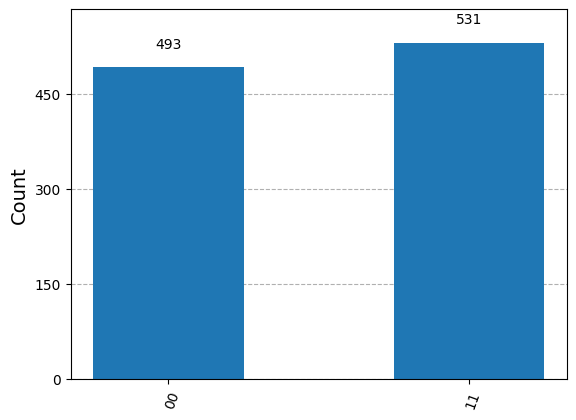

In [62]:
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = {k: sorted_counts[k] for k in list(sorted_counts.keys())[:10]}  # Top 10 results

plot_histogram(top_counts)
